In [1]:
import numpy as np
from typing import List, Tuple
from sum_func import get_kvc_size, get_latency, load_datasets
from piecewise_func import PiecewiseLinear

# default_model_name="meta-llama/Meta-Llama-3-8B"
# default_cuda_device_name="NVIDIA RTX A5000"
default_model_name="facebook/opt-30b"
default_cuda_device_name="NVIDIA A100 80GB PCIe"
data_content_conv = 'conv'
data_content_code = 'code'

dataset_frame_conv = load_datasets(_dataset_content = data_content_conv)
dataset_frame_code = load_datasets(_dataset_content = data_content_code)
kvc_size_in_gb = get_kvc_size(default_model_name)

def get_piecewise_list(dataset_frame):
    piecewise_func_list = []

    for index, request in dataset_frame.iterrows():
        start_timestamp = dataset_frame.loc[index, 'TIMESTAMP']
        prompt_len = dataset_frame.loc[index, 'ContextTokens']
        response_len = dataset_frame.loc[index, 'GeneratedTokens']
        prompt_latency, response_latency, total_latency=get_latency(
            _model_name = default_model_name,
            _cuda_device_name = default_cuda_device_name,
            _prompt_length = prompt_len,
            _response_length = response_len
        )

        piecewise_func_instance = PiecewiseLinear(
            start_x=start_timestamp,
            prompt_mem = kvc_size_in_gb * prompt_len,
            prompt_latency = prompt_latency,
            total_mem = kvc_size_in_gb * (prompt_len + response_len),
            total_latency = total_latency
            )
    
        piecewise_func_list.append(piecewise_func_instance)
    
    return piecewise_func_list

piecewise_list_conv = get_piecewise_list(dataset_frame_conv)
piecewise_list_code = get_piecewise_list(dataset_frame_code)

For gpu: NVIDIA A100 80GB PCIe, practical_mem_bw: 1200.0 GB/s, for model: facebook/opt-30b, kvc_size: 1344.0 KB, ptps=3586.6 tokens/s
For gpu: NVIDIA A100 80GB PCIe, practical_mem_bw: 1200.0 GB/s, for model: facebook/opt-30b, kvc_size: 1344.0 KB, ptps=3586.6 tokens/s
For gpu: NVIDIA A100 80GB PCIe, practical_mem_bw: 1200.0 GB/s, for model: facebook/opt-30b, kvc_size: 1344.0 KB, ptps=3586.6 tokens/s
For gpu: NVIDIA A100 80GB PCIe, practical_mem_bw: 1200.0 GB/s, for model: facebook/opt-30b, kvc_size: 1344.0 KB, ptps=3586.6 tokens/s
For gpu: NVIDIA A100 80GB PCIe, practical_mem_bw: 1200.0 GB/s, for model: facebook/opt-30b, kvc_size: 1344.0 KB, ptps=3586.6 tokens/s
For gpu: NVIDIA A100 80GB PCIe, practical_mem_bw: 1200.0 GB/s, for model: facebook/opt-30b, kvc_size: 1344.0 KB, ptps=3586.6 tokens/s
For gpu: NVIDIA A100 80GB PCIe, practical_mem_bw: 1200.0 GB/s, for model: facebook/opt-30b, kvc_size: 1344.0 KB, ptps=3586.6 tokens/s
For gpu: NVIDIA A100 80GB PCIe, practical_mem_bw: 1200.0 GB/s,

In [11]:
from matplotlib import pyplot as plt
plt.rc('font', size=14, weight='bold')  # Set all font sizes to 14 and make them bold
plt.rc('axes', titlesize=16, labelsize=14)  # Title size 16, labels size 14
plt.rc('axes', titleweight='bold', labelweight='bold')  # Bold title and labels
plt.rc('lines', linewidth=3)  # Set the default line width for plots
def generate_uniform_interpolation_points(start: float, end: float, points_per_second: int) -> np.ndarray:
    total_points = (end - start) * points_per_second
    return np.linspace(start, end, int(total_points))

interpolation_points = generate_uniform_interpolation_points(0, 3600, 10)

def sum_all_pw(pws: List[PiecewiseLinear]) -> Tuple[List[float], List[float]]:
    timestamp_list = []
    mem_list = []
    for interpolation_point in interpolation_points:
        cur_sum = 0
        for pw in pws:
            cur_sum += pw.interpolate(interpolation_point)
        
        timestamp_list.append(interpolation_point)
        mem_list.append(cur_sum)
        
    return (timestamp_list, mem_list)
            
result_conv = sum_all_pw(piecewise_list_conv)
result_code = sum_all_pw(piecewise_list_code)

def plot_sum_interpolation(_result_tuple, _model_name, data_content):
    plt.figure(figsize=(10, 6)) 
    model_parts=_model_name.split('/')
    #model_prefix=model_parts[0]
    model_suffix=model_parts[-1]
    
    timestamps = _result_tuple[0]
    mem_consumption = _result_tuple[1]
    
    plt.plot(timestamps, mem_consumption, label=f'Azure {data_content}', color='red', alpha=0.65, linewidth=1)
    #plt.plot(x_fine_code, y_fine_code, label='Azure code', color='blue', alpha=0.65, linewidth=1)
    plt.xlabel('Time(s)')
    plt.ylabel('Memory Usage(GB)')
    plt.title(f'Memory Usage of Two Traces(code and conv) \n for {model_suffix} Model')
    plt.legend()
    plt.grid(False)
    #plt.savefig(f'./plots/{model_name}/pwlinear_sum_comparison.png')
    plt.show()

def plot_sum_two_datasets(_result_conv, _result_code, _model_name):
    plt.figure(figsize=(10, 6)) 
    model_parts=_model_name.split('/')
    #model_prefix=model_parts[0]
    model_suffix=model_parts[-1]
    
    timestamps_conv = _result_conv[0]
    mem_consumption_conv = _result_conv[1]
    timestamps_code = _result_code[0]
    mem_consumption_code = _result_code[1]
    
    plt.plot(timestamps_conv, mem_consumption_conv, label=f'Azure conv', color='red', alpha=0.65, linewidth=1)
    plt.plot(timestamps_code, mem_consumption_code, label='Azure code', color='blue', alpha=0.65, linewidth=1)
    plt.xlabel('Time(s)')
    plt.ylabel('Memory Usage(GB)')
    plt.title(f'Memory Usage of Two Traces(code and conv) \n for {model_suffix} Model')
    plt.legend()
    plt.grid(False)
    #plt.savefig(f'./plots/{model_name}/pwlinear_sum_comparison.png')
    plt.show()
    
# plot_sum_two_datasets(_result_conv = result_conv, _result_code = result_code, _model_name = default_model_name)
        

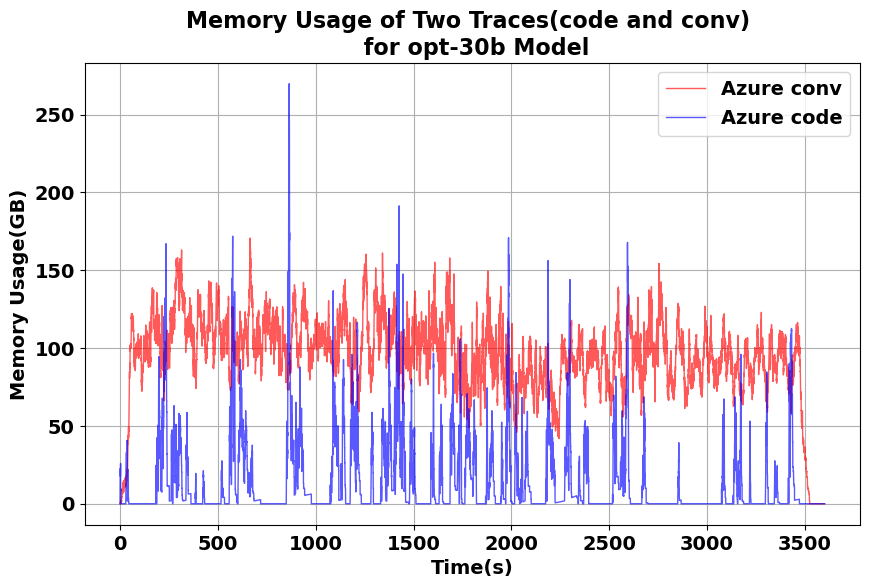

In [10]:
plt.rc('font', size=14, weight='bold')  # Set all font sizes to 14 and make them bold
plt.rc('axes', titlesize=16, labelsize=14)  # Title size 16, labels size 14
plt.rc('axes', titleweight='bold', labelweight='bold')  # Bold title and labels
plt.rc('lines', linewidth=3)  # Set the default line width for plots
plot_sum_two_datasets(_result_conv = result_conv, _result_code = result_code, _model_name = default_model_name)

In [8]:
import numpy as np
from scipy.signal import find_peaks

def find_peaks_and_calculate_slopes(timestamps, mem_consumption):
    # Convert the input lists to numpy arrays
    timestamps = np.array(timestamps)
    mem_consumption = np.array(mem_consumption)

    # Find peaks using scipy's find_peaks
    peaks_indices, _ = find_peaks(mem_consumption)

    peaks = []
    before_slopes = []

    # Loop through the indices of the peaks to calculate the before slopes
    for i in peaks_indices:
        peak_time = timestamps[i]
        peak_value = mem_consumption[i]
        peaks.append((peak_time, peak_value))
        
        # Calculate slope before the peak (if not the first point)
        if i > 0:
            slope_before = (mem_consumption[i] - mem_consumption[i-1]) / (timestamps[i] - timestamps[i-1])
        else:
            slope_before = None  # Not enough data to compute the slope

        before_slopes.append(slope_before)
    
    return peaks, before_slopes

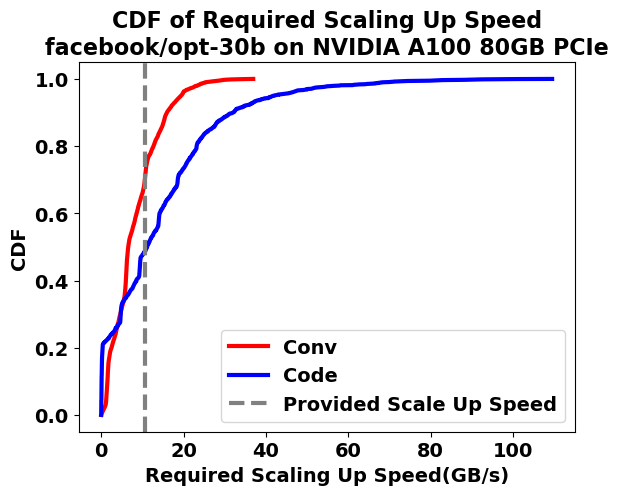

In [9]:
from utils import get_gpu_info, get_model_info
gpu_info = get_gpu_info(default_cuda_device_name)
model_info = get_model_info(default_model_name)
mem_cap_GB = gpu_info['memory_cap']
model_size_GB = model_info['model_size_GB']
kvc_size_in_gb = get_kvc_size(default_model_name)
PCIe_speed_GBS = 32
provided_scale_up_speed = (mem_cap_GB - model_size_GB) / (model_size_GB / PCIe_speed_GBS)

conv_timestamps = result_conv[0]
mem_consumption_conv = result_conv[1]
code_timestamps = result_code[0]
mem_consumption_code = result_code[1]

_, conv_peaks = find_peaks_and_calculate_slopes(conv_timestamps, mem_consumption_conv)
_, code_peaks = find_peaks_and_calculate_slopes(code_timestamps, mem_consumption_code)

conv_peaks_sorted = np.sort(conv_peaks)
code_peaks_sorted = np.sort(code_peaks)

# Calculate the CDF for both lists
conv_cdf = np.arange(1, len(conv_peaks_sorted)+1) / len(conv_peaks_sorted)
code_cdf = np.arange(1, len(code_peaks_sorted)+1) / len(code_peaks_sorted)

# Plot the CDFs
plt.plot(conv_peaks_sorted, conv_cdf, label='Conv', color='red')
plt.plot(code_peaks_sorted, code_cdf, label='Code', color='blue')
plt.axvline(provided_scale_up_speed, label='Provided Scale Up Speed', color='grey', linestyle='--')

# Add labels and title
plt.xlabel('Required Scaling Up Speed(GB/s)')
plt.ylabel('CDF')
plt.title(f'CDF of Required Scaling Up Speed\n{default_model_name} on {default_cuda_device_name}')

# Show the legend
plt.legend()

# Show the plot
plt.show()
